# Import Modules

In [1]:
import os
import pandas as pd
import numpy.random as rnd
import warnings
import json
import sqlalchemy as sql
import datetime
import yfinance as yf
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import objective_functions
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from MCForecastTools import MCSimulation
from bokeh.plotting import figure, output_file
from bokeh.resources import INLINE



%matplotlib inline

#warnings.filterwarnings("ignore")
#pd.options.display.float_format = '{:.4%}'.format

# Data Input for Universe (Multiple Asset Classes)

In [2]:
# Date range
today = datetime.date.today()
start_date = today - datetime.timedelta(days=365*5) #trading days(252) * amount of years to go back 

start = start_date.strftime("%Y-%m-%d")
end = today.strftime("%Y-%m-%d")

# Tickers of assets
assets = ["MSFT", "TSLA", "META", "UNH", "JNJ", "JPM", "V", "LLY", "AVGO", "PG", "MA", "HD", "MRK", "NVDA", "AMZN", "BRK-B",
         "GOOG", "XOM", "CVX", "PEP", "COST", "KO", "ABBV", "ADBE", "WMT", "MCD", "CSCO", "CRM"]
assets.sort()

# Downloading data
og_data = yf.download(assets, start = start, end = end)
data = og_data.loc[:,('Adj Close', slice(None))]
data.columns = assets

Y = data[assets].pct_change().dropna()

display(start)
display(end)
display(Y)

[*********************100%***********************]  28 of 28 completed


'2018-07-10'

'2023-07-09'

,ABBV,ADBE,AMZN,AVGO,BRK-B,COST,CRM,CSCO,CVX,GOOG,...,MRK,MSFT,NVDA,PEP,PG,TSLA,UNH,V,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-11,-0.039256,-0.002051,0.006844,-0.028416,0.000053,-0.003543,0.019656,-0.006766,-0.031899,0.000919,...,-0.006420,-0.001371,-0.022586,-0.003100,-0.008269,-0.010885,-0.003718,0.010681,-0.007797,-0.012790
2018-07-12,0.017128,0.027205,0.023715,-0.137447,0.000263,0.014553,0.020034,0.023726,0.005991,0.025635,...,0.012278,0.021671,0.014948,-0.008975,-0.003411,-0.007054,0.005735,0.012667,-0.000116,0.001211
2018-07-13,0.010668,0.014596,0.009134,-0.035813,0.005264,0.011775,-0.003712,-0.041303,-0.001771,0.004512,...,0.003671,0.011901,-0.007603,0.010401,0.005324,0.006820,0.010350,-0.003431,0.013639,0.007498
2018-07-16,-0.003932,-0.015120,0.005218,0.003902,0.005446,-0.007804,-0.004403,0.017233,-0.008546,-0.004172,...,-0.004770,-0.004932,-0.004492,0.002396,0.002774,-0.027503,-0.006649,-0.006886,-0.000684,-0.009843
2018-07-17,-0.008728,0.014253,0.011764,0.024895,-0.008281,0.000698,0.000408,-0.003765,-0.008701,0.012620,...,-0.000958,0.009913,0.022119,0.016997,0.006287,0.040600,-0.026033,0.008522,0.006275,-0.002182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,0.011259,0.010790,0.019234,0.005634,0.012140,0.012583,0.003944,0.010350,0.007104,0.007999,...,0.016294,0.016386,0.036255,0.007287,0.015799,0.016582,0.008815,0.013486,0.018797,0.005155
2023-07-03,0.002078,-0.007730,-0.001074,0.010387,0.002933,0.004941,0.001846,0.001546,-0.000890,-0.003389,...,-0.009186,-0.007488,0.002624,0.002052,0.005009,0.068954,-0.005742,0.002063,0.006489,0.001958
2023-07-05,0.019332,0.004225,0.001229,-0.016635,-0.001287,0.000166,0.010253,0.001555,-0.005725,0.017170,...,-0.005510,0.000473,-0.002263,0.005280,-0.001705,0.009506,-0.013937,0.006219,-0.000569,-0.005118


In [3]:
#Set the time period and trading days
rolling_window = 30
trading_days = 252

## Set up data for k-means model

In [4]:
# Calculate annual returns from daily returns
group_level = Y.index.year
annual_returns = Y.groupby(by=group_level).mean()
annual_returns

# Annual standard deviation
annual_stdev = annual_returns.std()*np.sqrt(trading_days)
annual_stdev.head()


ABBV     0.014888
ADBE     0.027685
AMZN     0.034345
AVGO     0.020959
BRK-B    0.004991
dtype: float64

In [5]:
# Calculate rolling 30 day returns from daily returns
thirty_day_rolling = Y.rolling(window = rolling_window).mean() 
thirty_day_rolling

# 30 day rolling standard deviation
thirty_day_stdev = thirty_day_rolling.std()*np.sqrt(rolling_window)
thirty_day_stdev.head()

ABBV     0.015856
ADBE     0.020975
AMZN     0.020782
AVGO     0.019311
BRK-B    0.012280
dtype: float64

In [6]:
# annual sharpe ratio
sharpe_ratio = (annual_returns /annual_stdev).mean()
sharpe_ratio.head()

ABBV     0.024666
ADBE     0.032429
AMZN     0.020432
AVGO     0.071445
BRK-B    0.120195
dtype: float64

In [7]:
# combine all of the measures of variablity into one dataframe
asset_quant_data = pd.concat([annual_stdev,thirty_day_stdev,sharpe_ratio], axis =1)
asset_quant_data.columns = ('annual_stdev','thirty_day_stdev','sharpe_ratio')
asset_quant_data

,annual_stdev,thirty_day_stdev,sharpe_ratio
ABBV,0.014888,0.015856,0.024666
ADBE,0.027685,0.020975,0.032429
AMZN,0.034345,0.020782,0.020432
AVGO,0.020959,0.019311,0.071445
BRK-B,0.004991,0.012280,0.120195
COST,0.015544,0.014008,0.053323
CRM,0.031115,0.021290,0.026432
CSCO,0.012588,0.015909,0.035156
CVX,0.021063,0.020658,0.014997
GOOG,0.026212,0.016598,0.030552


## k-means modeling to cluster assets

In [8]:
# using a standard scaler to scale the variability metrics to avoid bias in the model

scaled_data = StandardScaler()

asset_data_scaled = scaled_data.fit_transform(asset_quant_data[['annual_stdev','thirty_day_stdev','sharpe_ratio']])



In [9]:
# Create a DataFrame with the scaled data
asset_data_scaled = pd.DataFrame(
    asset_data_scaled,
    columns=asset_quant_data.columns
)

# Copy the asset names from the original data
asset_data_scaled["Asset_Name"] = asset_quant_data.index

# Set the asset_name column as index
asset_data_scaled = asset_data_scaled.set_index("Asset_Name")

# Display sample data
asset_data_scaled.head()

,annual_stdev,thirty_day_stdev,sharpe_ratio
Asset_Name,,,
ABBV,-0.362734,-0.226241,-0.780546
ADBE,0.312712,0.441692,-0.564882
AMZN,0.664171,0.416492,-0.898189
AVGO,-0.042319,0.224539,0.519017
BRK-B,-0.885042,-0.692919,1.873358


In [10]:
# Create a list with the number of k-values to try
# Use a range from 1 to 10
k = list(range(1,10))

In [11]:
# Create an empy list to store the inertia values
inertia = []

In [12]:
for i in k:
    k_model = KMeans(n_clusters = i, random_state = 1)
    k_model.fit(asset_data_scaled)
    inertia.append(k_model.inertia_)

In [13]:
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {"k":k, "inertia":inertia}

# Create a DataFrame with the data to plot the Elbow curve
elbow_df = pd.DataFrame(elbow_data)

#check dataframe
elbow_df.head()

,k,inertia
0,1,84.000000
1,2,40.924063
2,3,19.717388
3,4,12.379233
4,5,9.081638


In [14]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_df.hvplot.line(x = "k", y = "inertia", title = "Elbow Curve", xticks = k)

:Curve   [k]   (inertia)

In [15]:
# Initialize the K-Means model using the best value for k
model = KMeans (n_clusters = 4, random_state = 1)

In [16]:
# Fit the K-Means model using the scaled data
model.fit(asset_data_scaled)

KMeans(n_clusters=4, random_state=1)

In [17]:
# Predict the clusters to group the assets using the scaled data
k = model.predict(asset_data_scaled)

# View the resulting array of cluster values.
k

array([2, 2, 2, 1, 3, 1, 2, 1, 2, 2, 2, 1, 1, 1, 3, 1, 3, 0, 1, 1, 0, 3,
       1, 0, 1, 1, 3, 2])

In [18]:
# Create a copy of the DataFrame
asset_data_scaled_predict = asset_data_scaled.copy()

In [19]:
# Add a new column to the DataFrame with the predicted clusters
asset_data_scaled_predict["clusters"] = k

# Display sample data
asset_data_scaled_predict

,annual_stdev,thirty_day_stdev,sharpe_ratio,clusters
Asset_Name,,,,
ABBV,-0.362734,-0.226241,-0.780546,2
ADBE,0.312712,0.441692,-0.564882,2
AMZN,0.664171,0.416492,-0.898189,2
AVGO,-0.042319,0.224539,0.519017,1
BRK-B,-0.885042,-0.692919,1.873358,3
COST,-0.328091,-0.467426,0.015576,1
CRM,0.493722,0.482782,-0.731495,2
CSCO,-0.484126,-0.219269,-0.489120,1
CVX,-0.036833,0.400414,-1.049167,2


## Charts and summary of k-means

In [20]:
# Create a scatter plot using hvPlot by setting 
# `x="Sharpe Ratio"` and `y="Annual Average Returns"`. 
# Color the graph points with the labels found using K-Means and 
# the assets represented by each data point.
asset_data_scaled_predict.hvplot.scatter(
    x="annual_stdev", 
    y="sharpe_ratio",
    by = "clusters",
    title = 'k-means features plot',
    hover_cols = "Asset_Name").opts(yformatter="%.0f")


:NdOverlay   [clusters]
   :Scatter   [annual_stdev]   (sharpe_ratio,Asset_Name)

## Translating the k-means model output into segmented portfolios

<Axes: title={'center': 'Cumulative Returns of Assets in Universe over the Last 5 Years'}, xlabel='asset_name', ylabel='Return over 5yrs %'>

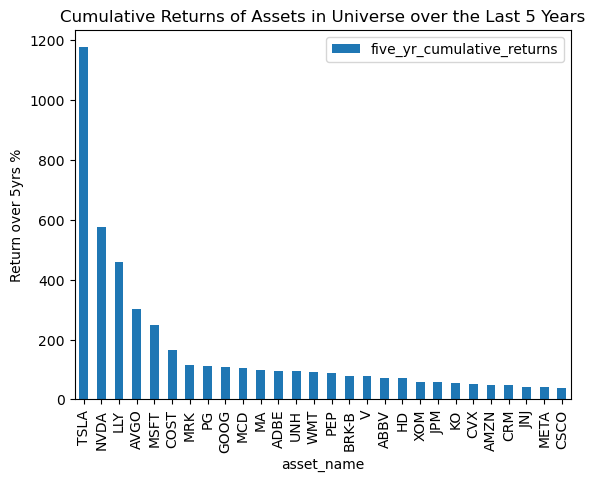

In [21]:
# calculate the cumulative returns over the entire data period 
cumulative_returns = round(((1+Y).cumprod()-1)*100, 3)

# select the last date in the period as the cumulative returns
# reset the index and transpose the row
asset_cumulative_returns = cumulative_returns.tail(1).T.reset_index()

# rename the columns to new data frame with the ticker as 'asset_name',
# and the cumulative returns as 'five_yr_cumulative_returns'
asset_cumulative_returns.columns = list(['asset_name','five_yr_cumulative_returns'])

#set asset name as new index
asset_cumulative_returns = asset_cumulative_returns.set_index('asset_name')

#sort the cumulative returns by higest to lowest
asset_cumulative_returns.sort_values(by = ['five_yr_cumulative_returns'], ascending = False,
                                    inplace = True)
asset_cumulative_returns

# plot the cumulative
asset_cumulative_returns.plot.bar(title="Cumulative Returns of Assets in Universe over the Last 5 Years",
                                 ylabel = 'Return over 5yrs %')
# save the chart to the images folder


In [22]:
cumulative_returns.hvplot.line(title = 'Cumulative Returns over 5yrs',
                              ylabel = 'Returns %',
                              )              

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [23]:
predicted_cluster_df = pd.concat([asset_data_scaled_predict,asset_cumulative_returns], axis =1).dropna()
predicted_cluster_df

,annual_stdev,thirty_day_stdev,sharpe_ratio,clusters,five_yr_cumulative_returns
ABBV,-0.362734,-0.226241,-0.780546,2,73.120
ADBE,0.312712,0.441692,-0.564882,2,95.178
AMZN,0.664171,0.416492,-0.898189,2,48.910
AVGO,-0.042319,0.224539,0.519017,1,302.051
BRK-B,-0.885042,-0.692919,1.873358,3,79.516
COST,-0.328091,-0.467426,0.015576,1,165.211
CRM,0.493722,0.482782,-0.731495,2,47.132
CSCO,-0.484126,-0.219269,-0.489120,1,38.387
CVX,-0.036833,0.400414,-1.049167,2,50.499
GOOG,0.234954,-0.129426,-0.617030,2,108.424


In [24]:
# Plot cumulative returns vs. stdanrd deviation to identify features within the cluster

cluster0 = predicted_cluster_df.where(predicted_cluster_df['clusters']==0).dropna()
cluster0

fig0=cluster0.hvplot.scatter(x = 'annual_stdev',
                             y = 'five_yr_cumulative_returns',
                             hover_cols = 'all',
                             ylabel = '% returns',
                             by = 'clusters',
                             title="Five Cumulative Returns vs. Annual Standard Deviation")


In [25]:
cluster1 = predicted_cluster_df.where(asset_data_scaled_predict['clusters']==1).dropna()
cluster1

fig1=cluster1.hvplot.scatter(x = 'annual_stdev',
                             y = 'five_yr_cumulative_returns',
                             hover_cols = 'all',
                             by = 'clusters',
                             title="Cumulative Returns of Assets in Cluster 1 over the Last 5 Years")

In [26]:
cluster2 = predicted_cluster_df.where(asset_data_scaled_predict['clusters']==2).dropna()
cluster2

fig2=cluster2.hvplot.scatter(x = 'annual_stdev',
                             y = 'five_yr_cumulative_returns',
                             hover_cols = 'all',
                              by = 'clusters',
                             title="Cumulative Returns of Assets in Cluster 2 over the Last 5 Years")

In [27]:
cluster3 = predicted_cluster_df.where(asset_data_scaled_predict['clusters']==3).dropna()
cluster3

fig3=cluster3.hvplot.scatter(x = 'annual_stdev',
                             y = 'five_yr_cumulative_returns',
                             hover_cols = 'all',
                              by = 'clusters',
                             title="Cumulative Returns of Assets in Cluster 3 over the Last 5 Years")

In [28]:
#plot clusters together
fig =fig0 * fig1 * fig2 *fig3
fig

#fig.savefig('images/cumulative_returns_vs_stdev.png', bbox_inches ='tight')

:Overlay
   .NdOverlay.I   :NdOverlay   [clusters]
      :Scatter   [annual_stdev]   (five_yr_cumulative_returns,index,thirty_day_stdev,sharpe_ratio,clusters)
   .NdOverlay.II  :NdOverlay   [clusters]
      :Scatter   [annual_stdev]   (five_yr_cumulative_returns,index,thirty_day_stdev,sharpe_ratio,clusters)
   .NdOverlay.III :NdOverlay   [clusters]
      :Scatter   [annual_stdev]   (five_yr_cumulative_returns,index,thirty_day_stdev,sharpe_ratio,clusters)
   .NdOverlay.IV  :NdOverlay   [clusters]
      :Scatter   [annual_stdev]   (five_yr_cumulative_returns,index,thirty_day_stdev,sharpe_ratio,clusters)

In [29]:
# Grouping the clusters by the 'five_yr_cumulative_returns' and the 'annual_stdev'
# this will give us our features to characterize our porfolio
cluster_characteristics = predicted_cluster_df.groupby("clusters").mean()[['five_yr_cumulative_returns','annual_stdev','thirty_day_stdev','sharpe_ratio']]
cluster_characteristics

# box plot of the returns if we increase the universe
# this shows the distrbution of the returns
#box_plot_returns = cluster_characteristics.hvplot.box(y ='five_yr_cumulative_returns',
                                                      #by = 'clusters',
                                                     # height=400, width=400,
                                                     # title="Returns by Cluster")
#box_plot_returns


,five_yr_cumulative_returns,annual_stdev,thirty_day_stdev,sharpe_ratio
clusters,,,,
0,598.928000,2.606717,2.352002,-0.702376
1,117.370333,-0.440418,-0.475664,-0.033104
2,69.497375,0.179457,0.242803,-0.825784
3,164.640600,-0.794159,-0.658092,1.822130


In [30]:
# function 'label_clusters' takes our cluster characterisitcs and segments them
# based on how the features within the clusters vary from the median

def label_clusters(row):
    if row['annual_stdev'] > cluster_characteristics['annual_stdev'].median() and row['five_yr_cumulative_returns'] > cluster_characteristics['five_yr_cumulative_returns'].median():
        return 'HighRisk-HighReturn'
    elif row['annual_stdev'] < cluster_characteristics['annual_stdev'].median() and row['five_yr_cumulative_returns'] < cluster_characteristics['five_yr_cumulative_returns'].median():
        return 'LowRisk-LowReturn'
    else:
        return 'MediumRisk-MediumReturn'

cluster_characteristics['cluster_label'] = cluster_characteristics.apply(label_clusters, axis=1)

portfolio_segments = predicted_cluster_df.copy()
portfolio_segments['cluster_label'] = portfolio_segments['clusters'].map(cluster_characteristics['cluster_label'])
portfolio_segments.sort_values(by = ['cluster_label'], ascending = False, inplace = True)
portfolio_segments

,annual_stdev,thirty_day_stdev,sharpe_ratio,clusters,five_yr_cumulative_returns,cluster_label
ABBV,-0.362734,-0.226241,-0.780546,2,73.120,MediumRisk-MediumReturn
CVX,-0.036833,0.400414,-1.049167,2,50.499,MediumRisk-MediumReturn
WMT,-0.795798,-0.749679,1.191315,3,92.017,MediumRisk-MediumReturn
PEP,-0.838077,-1.046392,0.969526,3,87.108,MediumRisk-MediumReturn
MCD,-0.850949,-0.749301,2.116622,3,104.369,MediumRisk-MediumReturn
ADBE,0.312712,0.441692,-0.564882,2,95.178,MediumRisk-MediumReturn
HD,-0.146697,-0.139522,-0.868469,2,72.977,MediumRisk-MediumReturn
GOOG,0.234954,-0.129426,-0.617030,2,108.424,MediumRisk-MediumReturn
LLY,-0.600928,-0.052168,2.959827,3,460.193,MediumRisk-MediumReturn
XOM,0.276365,0.696231,-1.096494,2,59.739,MediumRisk-MediumReturn


## Hardcode the client data

In [43]:
#hardcode inputs from amazon lex 
investment_amount = 100000
#retirement = 5

In [32]:
# test score data score Medium risk and medium return
aggregate_client_score = 3

## Read JSON file output from BOT

In [33]:
# read in json file from Amazon Lex BOT
saved_response_path = Path('profile_data.json')

In [34]:
# Create a dictionary for the json object
response = {}

# Read json object into dictionary
with open(saved_response_path, "r") as file_handle:
    response = json.load(file_handle)

In [35]:
# print  JSON file to check variables
print(json.dumps(response, indent=3))

{
   "name": "Oz",
   "investment_amount": 25000,
   "current_age": 32,
   "years_until_retirement": 28,
   "risk_total": 13.0,
   "retirement_date": "2051-07-03"
}


In [36]:
# reassign input variables based on JSON file from Amazon Lex BOT
# once the JSON file is read in, the client variables will be updated
aggregate_client_score = response['risk_total']
#investment_amount = response['investment_amount']
retirement = response['years_until_retirement']

## Selecting a portfolio based on client risk profile

In [37]:
# function that is used to pick a portfolio for the client
# aggregate client score is then used to determine the
# 'LowRisk-LowReturn','HighRisk-HighReturn','MediumRisk-MediumReturn' portfolio

def get_matching_clusters(aggregate_client_score, portfolio_segments):
    if aggregate_client_score < 7:
        target_label = 'LowRisk-LowReturn'
    elif aggregate_client_score > 14:
        target_label = 'HighRisk-HighReturn'
    else:
        target_label = 'MediumRisk-MediumReturn'
    
#Filter the dataframe for the target label
    matching_cluster = portfolio_segments[portfolio_segments['cluster_label'] == target_label]
    
    return matching_cluster
    
# portfolio selected
matching_cluster = get_matching_clusters(aggregate_client_score, portfolio_segments)
matching_cluster

,annual_stdev,thirty_day_stdev,sharpe_ratio,clusters,five_yr_cumulative_returns,cluster_label
ABBV,-0.362734,-0.226241,-0.780546,2,73.120,MediumRisk-MediumReturn
CVX,-0.036833,0.400414,-1.049167,2,50.499,MediumRisk-MediumReturn
WMT,-0.795798,-0.749679,1.191315,3,92.017,MediumRisk-MediumReturn
PEP,-0.838077,-1.046392,0.969526,3,87.108,MediumRisk-MediumReturn
MCD,-0.850949,-0.749301,2.116622,3,104.369,MediumRisk-MediumReturn
ADBE,0.312712,0.441692,-0.564882,2,95.178,MediumRisk-MediumReturn
HD,-0.146697,-0.139522,-0.868469,2,72.977,MediumRisk-MediumReturn
GOOG,0.234954,-0.129426,-0.617030,2,108.424,MediumRisk-MediumReturn
LLY,-0.600928,-0.052168,2.959827,3,460.193,MediumRisk-MediumReturn
XOM,0.276365,0.696231,-1.096494,2,59.739,MediumRisk-MediumReturn


In [38]:
# creating a list of assets that will be used to build the porfolio
targeted_cluster_list = []
targeted_cluster_list = matching_cluster.index.tolist()
targeted_cluster_list

['ABBV',
 'CVX',
 'WMT',
 'PEP',
 'MCD',
 'ADBE',
 'HD',
 'GOOG',
 'LLY',
 'XOM',
 'CRM',
 'AMZN',
 'BRK-B']

## Portfolio Optimization

*Optimal Weighted Portfolio on Cluster based on user input*

In [39]:
today = datetime.date.today()
start_date = today - datetime.timedelta(days=365*5) #trading days(252) * amount of years to go back 

start = start_date.strftime("%Y-%m-%d")
end = today.strftime("%Y-%m-%d")

cluster_stock_data = yf.download(targeted_cluster_list, start = start, end = end)
adj_close_prices = cluster_stock_data.loc[:,('Adj Close', slice(None))]
adj_close_prices.columns = targeted_cluster_list

display(start)
display(end)
display(adj_close_prices)

[*********************100%***********************]  13 of 13 completed


'2018-07-10'

'2023-07-09'

,ABBV,CVX,WMT,PEP,MCD,ADBE,HD,GOOG,LLY,XOM,CRM,AMZN,BRK-B
Date,,,,,,,,,,,,,
2018-07-10,78.269440,248.630005,87.153503,189.899994,142.449997,102.472359,57.641998,175.057739,80.700768,142.928009,97.847168,79.935776,64.580505
2018-07-11,75.196938,248.119995,87.750000,189.910004,145.250000,99.203590,57.695000,174.473053,80.251648,141.148315,97.543808,79.312500,63.754520
2018-07-12,76.484886,254.869995,89.831001,189.960007,148.160004,99.797913,59.174000,175.358948,81.488968,141.593246,96.668396,79.303329,63.831726
2018-07-13,77.300858,258.589996,90.651497,190.960007,147.610001,99.621223,59.441002,176.014496,82.222206,141.050461,97.673828,80.384933,64.310318
2018-07-16,76.996872,254.679993,91.124496,192.000000,146.960007,98.769905,59.193001,176.182800,81.635605,141.290710,97.907829,80.329910,63.677334
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,134.729996,488.989990,130.360001,341.000000,211.259995,157.350006,120.970001,310.640015,468.980011,298.410004,185.220001,157.179993,107.250000
2023-07-03,135.009995,485.209991,130.220001,342.000000,211.649994,157.210007,120.559998,310.019989,461.420013,294.839996,185.600006,158.199997,107.459999
2023-07-05,137.619995,487.260010,130.380005,341.559998,213.820007,156.309998,122.629997,310.799988,465.700012,296.899994,186.580002,158.110001,106.910004


In [40]:
mu = mean_historical_return(adj_close_prices)
S = CovarianceShrinkage(adj_close_prices).ledoit_wolf()

ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
cleaned_weights

OrderedDict([('ABBV', 0.0),
             ('CVX', 0.0),
             ('WMT', 0.0),
             ('PEP', 0.03873),
             ('MCD', 0.0),
             ('ADBE', 0.0),
             ('HD', 0.07495),
             ('GOOG', 0.0),
             ('LLY', 0.57439),
             ('XOM', 0.14996),
             ('CRM', 0.04388),
             ('AMZN', 0.11809),
             ('BRK-B', 0.0)])

In [41]:
ef.portfolio_performance(verbose=True)

Expected annual return: 29.9%
Annual volatility: 21.8%
Sharpe Ratio: 1.28


(0.2994650792885206, 0.21768267161494143, 1.2838186761271746)

In [44]:
latest_prices = get_latest_prices(adj_close_prices)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=investment_amount) #total_portfolio_value=100000 CHANGE THIS TO OUTPUT FROM LEX ANSWER
allocation, leftover = da.lp_portfolio()
allocation

{'PEP': 11, 'HD': 62, 'LLY': 127, 'XOM': 51, 'CRM': 24, 'AMZN': 77}

In [ ]:
allocation_weights = []
for key in allocation:
    allocation_weights.append(allocation[key])

total_shares = sum(allocation_weights)
total_shares

allocation_weights = [x / total_shares for x in allocation_weights]
allocation_weights  

allocated_tickers = list(allocation.keys())
allocated_tickers

In [ ]:
dfs = []

for ticker in allocated_tickers:
    data = yf.download(ticker, start, interval='1d')
    open_df = pd.DataFrame(data['Open']).rename(columns={'Open': 'open'})
    adj_close_df = pd.DataFrame(data['Adj Close']).rename(columns={'Adj Close': 'close'})
    daily_return_df = pd.DataFrame(data['Adj Close'].pct_change()).rename(columns={'Adj Close': 'daily_return'})
    dfs.append(pd.concat([open_df, adj_close_df, daily_return_df], axis=1, keys=[ticker]*3))

allocated_data = pd.concat(dfs, axis=1).dropna()
allocated_data 

In [ ]:
allocated_closing_prices = adj_close_prices[allocated_tickers]
allocated_closing_prices

In [ ]:
investment_timeframe = retirement
monte_carlo_simulation = MCSimulation(
    portfolio_data= allocated_data,
    weights=allocation_weights,
    num_simulation=500,
    num_trading_days=252*investment_timeframe,
)

monte_carlo_simulation.portfolio_data.head()

In [ ]:
monte_carlo_simulation.calc_cumulative_return()

In [ ]:
monte_carlo_simulation.plot_simulation()

In [ ]:
monte_carlo_simulation.plot_distribution()

In [ ]:
monte_carlo_simulation_statistics = monte_carlo_simulation.summarize_cumulative_return()
monte_carlo_simulation_statistics

In [ ]:
ci_lower_ten_cumulative_return = monte_carlo_simulation_statistics[8]
ci_upper_ten_cumulative_return = monte_carlo_simulation_statistics[9]

In [ ]:
print(f"There is a 95% chance that the portfolio will provide returns within in the range of"
      f" {ci_lower_ten_cumulative_return: .2f} and {ci_upper_ten_cumulative_return: .2f} percent"
      f" over {investment_timeframe: .0f} years")